## Sunny OSM

This notebook aims to show a data processing and enriching pipeline to create a collection of data, that can be explored in ARLAS afterwards.

This is also a first look into the approach of a data scientist to propose an answer to a client's question, by using open datasets and common (big) data processing tools. 

### Technical pre-requisistes

- python 3.10 ([Download](https://wiki.python.org/moin/BeginnersGuide/Download))
- python requirements `pip install -r requirements.txt`

### Situation

You are working in an engineering office in the domain of renewable energies. Your company wants to study the photovoltaic potential of the buildings of Lozère, to increase the green electricity production, in order to decrease fossil fuels usage.

### Lozère

Lozère is the least populated French department. Created in 1790, this mountainous area is famous for its beautiful landscapes like the Tarn Gorges, or one of its famous myth, the beast of Gévaudan.

In order to make the department more attractive to new residents as well as to potential economic and industrial activities, some cities and groups of cities want to evaluate the potential of their land.

### Questions

You have to answer a few questions about the potential of this French department, that need to be justified with screenshots from the analytical geospatial platform ARLAS.

- What could be the electrical production if all parkings were covered by solar panels?
- What surface of buildings in the department?
- What could be the electrical production if half of the building of the towns that are part of the community of communes Coeur de Lozère?
- What town has the biggest production potential?

### Preliminary questions

Given the questions that are asked, what information is needed in the data?

### The data

In order to answer the questions above, we propose to use the three following open databases/data.

#### OSM

[OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap) (abbreviated OSM) is a website that uses an open geographic database which is updated and maintained by a community of volunteers via open collaboration. Contributors collect data from surveys, trace from aerial photo imagery or satellite imagery, and also import from other freely licensed geodata sources. OpenStreetMap is freely licensed under the Open Database License and as a result commonly used to make electronic maps, inform turn-by-turn navigation, assist in humanitarian aid and data visualisation. OpenStreetMap uses its own topology to store geographical features which can then be exported into other GIS file formats. The OpenStreetMap website itself is an online map, geodata search engine and editor.

OSM data is a very valuable tool when it comes to datascience as it can bring freely licensed building data quite reliably all across the globe. In order to limit the volume of the downloaded data, websites like [Geofabrik's](https://www.geofabrik.de/data/download.html) are particularly helpful to easily select a chunk of the data, here Languedoc-Roussillon.

#### ADMIN Express

[The National Institute of Geographic and Forest Information (IGN)](https://www.ign.fr/institut/identity-card) is a public administrative establishment placed under the joint authority of the Ministries in charge of ecology and forestry. Their goal is to guarantee the availability of geolocalised data and in particular sovereign data for the State, foster the appropriation and use of geographic data as well as maintain a high level of competence in the field of geographic information.

They produce a wide variety of interesting datasets when working with French geospatial data, as they give us information to enrich our own data with, for a better exploration. In this example, we will use their [ADMIN Express](https://geoservices.ign.fr/adminexpress) dataset to add the town info to each OSM building.

#### Photovoltaic potential

[Solargis](https://solargis.com) is a Slovakian company that provides online access to high-resolution solar data and services around the domain of solar energy. They provide regional and [by country](https://solargis.com/resources/free-maps-and-gis-data?locality=france) solar resource maps that can be used as is or, in our case, to enrich data.

### Transforming data formats

The OSM data can be retrieved from the official OpenStreetMap website. It is only possible to extract polygons but the drawing of the whole Languedoc-Roussillon can be tedious if we want to make sure that we get all the data from the region. 
Geofabrik proposes the OSM data packaged by region, country or vast area of interest, which allows to limit drastically the size of the downloaded archive.

The resulting file is in shapelfile format. For the big data processing tools we will use to process and enrich the data, this file format is not natively compatible, so we need to convert it into a csv file for example.

In [ ]:
""" Get absolute path to data """
import os
import sys

# Add arlas_playground root path to python path (first python path is the folder containing the notebook)
sys.path.append(os.path.dirname(os.path.dirname(sys.path[0])))

from tools.data_access import download_files_from_bucket, PROJECT_ROOT, get_absolute_local_path


LOCAL_DATA_PATH = os.path.join(PROJECT_ROOT, "tutorials/sunny_osm/data")


# osm_shp = get_absolute_local_path("sunny_osm/languedoc-roussillon_OSM/gis_osm_buildings_a_free_1.shp", local_data_path=LOCAL_DATA_PATH)
osm_csv = get_absolute_local_path("sunny_osm/osm.csv", local_data_path=LOCAL_DATA_PATH)
osm_csv

Since the Shapefile is quite voluminous, the processing was done before hand, including a selection of only the buildings with a type, in order to limit the size of the dataset. The files are available on the [public Gisaïa bucket](https://console.cloud.google.com/storage/browser/gisaia-public/demo/sunny_osm).

#### pandas

[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language. It allows to easily manipulate csv, json, hdf5 files and create series or dataframes to analyse and transform data.

#### GeoPandas

[GeoPandas](https://geopandas.org/en/stable/getting_started/introduction.html) is an extension of pandas that allows to better handle geospatial data, by adding new ways to read, process and write the data.

In [2]:
""" Create a dataframe from a shapefile """
import geopandas as gpd
import pandas as pd

# pandas_df = pd.DataFrame(gpd.read_file(osm_shp).dropna(subset=["geometry"]))
# pandas_df.head(10)

In [ ]:
""" Convert the dataframe to csv """
# pandas_df.to_csv(osm_csv, index=False)

### Enriching the data
#### Spark

[Apache Spark™](https://spark.apache.org/) is a multi-language engine for executing data engineering, data science, and machine learning on single-node machines or clusters. It allows to process in parallel large amount of data (query, transform, aggregate, reduce, ...).

It is originally in Scala, but has a python library offering great performances, and compatibility with a lot of pre-existing data science tools. This is the tool we will use the most in this notebook.

To use Spark, we need to create a local session (it could be on a remote cluster as well), in order to then submit actions to that cluster which will be processed in parallel.

Since we will perform a lot of spatial operations, we are using a Sedona session.
[Sedona](https://sedona.apache.org/latest/setup/overview/) is a geospatial extension to Spark (much like GeoPandas is to pandas), and will allow us to effectively get for each OSM building the town in which it is.

In [ ]:
""" Create a spark session """

import pyspark
import pyspark.sql
import sedona.spark

config = sedona.spark.SedonaContext.builder() \
    .config('spark.jars.packages',
            'org.apache.sedona:sedona-spark-shaded-3.5_2.12:1.6.0,'
            'org.datasyslab:geotools-wrapper:1.6.0-28.2') \
    .config('spark.jars.repositories', 'https://artifacts.unidata.ucar.edu/repository/unidata-all') \
    .getOrCreate()

SPARK: pyspark.sql.SparkSession = sedona.spark.SedonaContext.create(config)
SPARK.sparkContext.setSystemProperty("sedona.global.charset", "utf8")

#### Discovering the OSM data

We are first going to explore the OSM data of the Languedoc-Roussillon region and see what information it contains.

In [ ]:
""" Load the data and display the structure """
df = SPARK.read.option("header", "true").csv(osm_csv)
df

Even though we just read the data from the CSV created above, no data is displayed. That is because Spark processes "lazily" the data. It creates a plan of operations and transformations to be performed, but only performs them when asked to by certain commands, like below.

Here is a brief description of the fields of this file:
- osm_id -> unique id for this OSM feature
- code -> code of the feature type, here only 1500
- fclass -> type of feature, here only building
- name -> name of the feature
- type -> type of the building
- area -> area in square meters
- geometry -> WKT of the building

In [ ]:
""" Display the first ten rows """
df.show(10)

In [ ]:
""" Aggregate by building type """
df.groupBy("type").count()

Once again, Spark does not directly compute the result of such aggregation, it needs to be "collected".

In [ ]:
df.groupBy("type").count().sort('count', ascending=False).collect()

To have a better understanding of what the data can contain and its diversity, try changing the field you aggregate the data on, or even other aggregations.

#### Enrich OSM with administrative data

The IGN creates the [ADMIN EXPRESS](https://geoservices.ign.fr/adminexpress) dataset that presents the administrative limits of all towns of France. This will help us to have information per town, as well as to easily filter the data only on the towns that can interest us. 

The ADMIN EXPRESS file contains all metropolitan French communes, so we will need to filter them in order to get the ones which interest us. The files are shapefile, so they will need to be converted once again.

In [10]:
commune_shp = get_absolute_local_path("sunny_osm/commune_IGN/COMMUNE.shp", local_data_path=LOCAL_DATA_PATH)
commune_csv = get_absolute_local_path("sunny_osm/commune.csv", local_data_path=LOCAL_DATA_PATH)

# Skipped to avoid downloading 500MB
# pd.DataFrame(gpd.read_file(commune_shp)).to_csv(commune_csv, index=False)

In [ ]:
commune_df = SPARK.read.option("header", "true").csv(commune_csv)
commune_df

Among all the fields available only a few interest us:
- NOM -> name of the commune
- INSEE_DEP -> name of the department
- INSEE_REG -> name of the region

Fields like `POPULATION` could bring another dimension through which to filter the data once in ARLAS. If you have time, consider adding it to your data.

In [ ]:
commune_df.count()

Let's reduce the number of communes by limiting ourselves to the ones in Lozère.

In [ ]:
commune_df.filter(commune_df.INSEE_DEP == "48").count()

In [ ]:
import pyspark.sql.functions as F

lozere_df = commune_df.filter(commune_df.INSEE_DEP == "48") \
    .withColumn("region", F.lit("Occitanie")) \
    .withColumn("department", F.lit("Lozère")) \
    .withColumnRenamed("NOM", "commune") \
    .select("region", "department", "commune", "geometry")
lozere_df.head(10)

When comparing those coordinates to the ones of the OSM dataset, what do you notice?

The coordinates in the two datasets are not in the same coordinate system, on top of one being in meters while the other is in degrees. We will need to put both in the same referential in order to be able to cross the data.

In [ ]:
""" Convert geometry columns to Sedona geometries and to same CRS """
import sedona
import sedona.spark

lozere_df = lozere_df.withColumn("geometry", sedona.spark.ST_GeomFromWKT("geometry")) \
    .withColumn("geometry", sedona.spark.ST_Transform(
        "geometry", F.lit("EPSG:2154"), F.lit("EPSG:4326")))
lozere_df.head(10)

Now we can add the administrative information to the OSM buildings by crossing the two information.

Since we are going to perform a spatial join of the two datasets, are going to utilize Sedona's geographical processing abilities.

In [ ]:
""" Load OSM data and convert geometry columns to Sedona geometries """
osm_df = df \
    .withColumn("geometry", sedona.spark.ST_GeomFromWKT("geometry")) \
    .withColumn("centroid", sedona.spark.ST_Centroid("geometry"))
osm_df.head(10)

Spark's python library offers neatly packaged method that can be used directly as above, but it also allows us to directly use the SQL syntax to perform selections and transformations. However, we need to indicate to Spark how we are going to refer to the dataframes while in SQL mode. For that, we create a Temporary View of the dataframe.

In [17]:
""" Create in the "SQL environment" of Spark the datasets """
osm_df.createOrReplaceTempView("osm")
lozere_df.createOrReplaceTempView("commune")

In [ ]:
""" Join the datasets using SQL notation """
osm_enriched_df = SPARK.sql("""
    SELECT osm.geometry as geometry, osm.name as name, osm.osm_id as osm_id,
        osm.type as type, osm.centroid as centroid, osm.area as area,
        commune.commune as commune, commune.department as department,
        commune.region as region
    FROM commune, osm
    WHERE ST_Contains(commune.geometry, osm.centroid)
""")
osm_enriched_df.head(10)

In this spatial join, we `SELECT` all the columns that interest us from both dataframes, if and only if the centroid of the OSM building is contained in the geometry describing the commune. The method used `ST_CONTAINS` comes from Sedona, but can be simple operations like mathematical operations.

Once done, we convert back the geometry column of the resulting dataframe to WKT format, to facilitate further processing.

In [19]:
osm_enriched_df = osm_enriched_df \
    .withColumn("geometry", sedona.spark.ST_AsText("geometry")) \
    .withColumn("centroid", sedona.spark.ST_AsText("centroid"))

With the data as it is, we have an enriched version of the Lozère OSM data with a few administrative data that will give us another option in filtering data when exploring the dataframe with ARLAS.

In order to limit the amount of operations that are stored in Spark and will be executed once we write the data, we choose to write and then reload the data at this point.

In [33]:
osm_enriched_json = get_absolute_local_path("sunny_osm/osm_admin_enriched.json", local_data_path=LOCAL_DATA_PATH)
osm_enriched_df.write.mode('overwrite').json(osm_enriched_json)

In [20]:
""" Remove dataframe from memory """
del osm_enriched_df

To explore the photovoltaic potential, we will as a last step, use the monthly average of photovoltaic potential from 1994 to 2018 computed by Solargis. On their website they propose already generated map that offer an overview of the photovoltaic power potential of a country or a region of the globe; as well as yearly and monthly average.

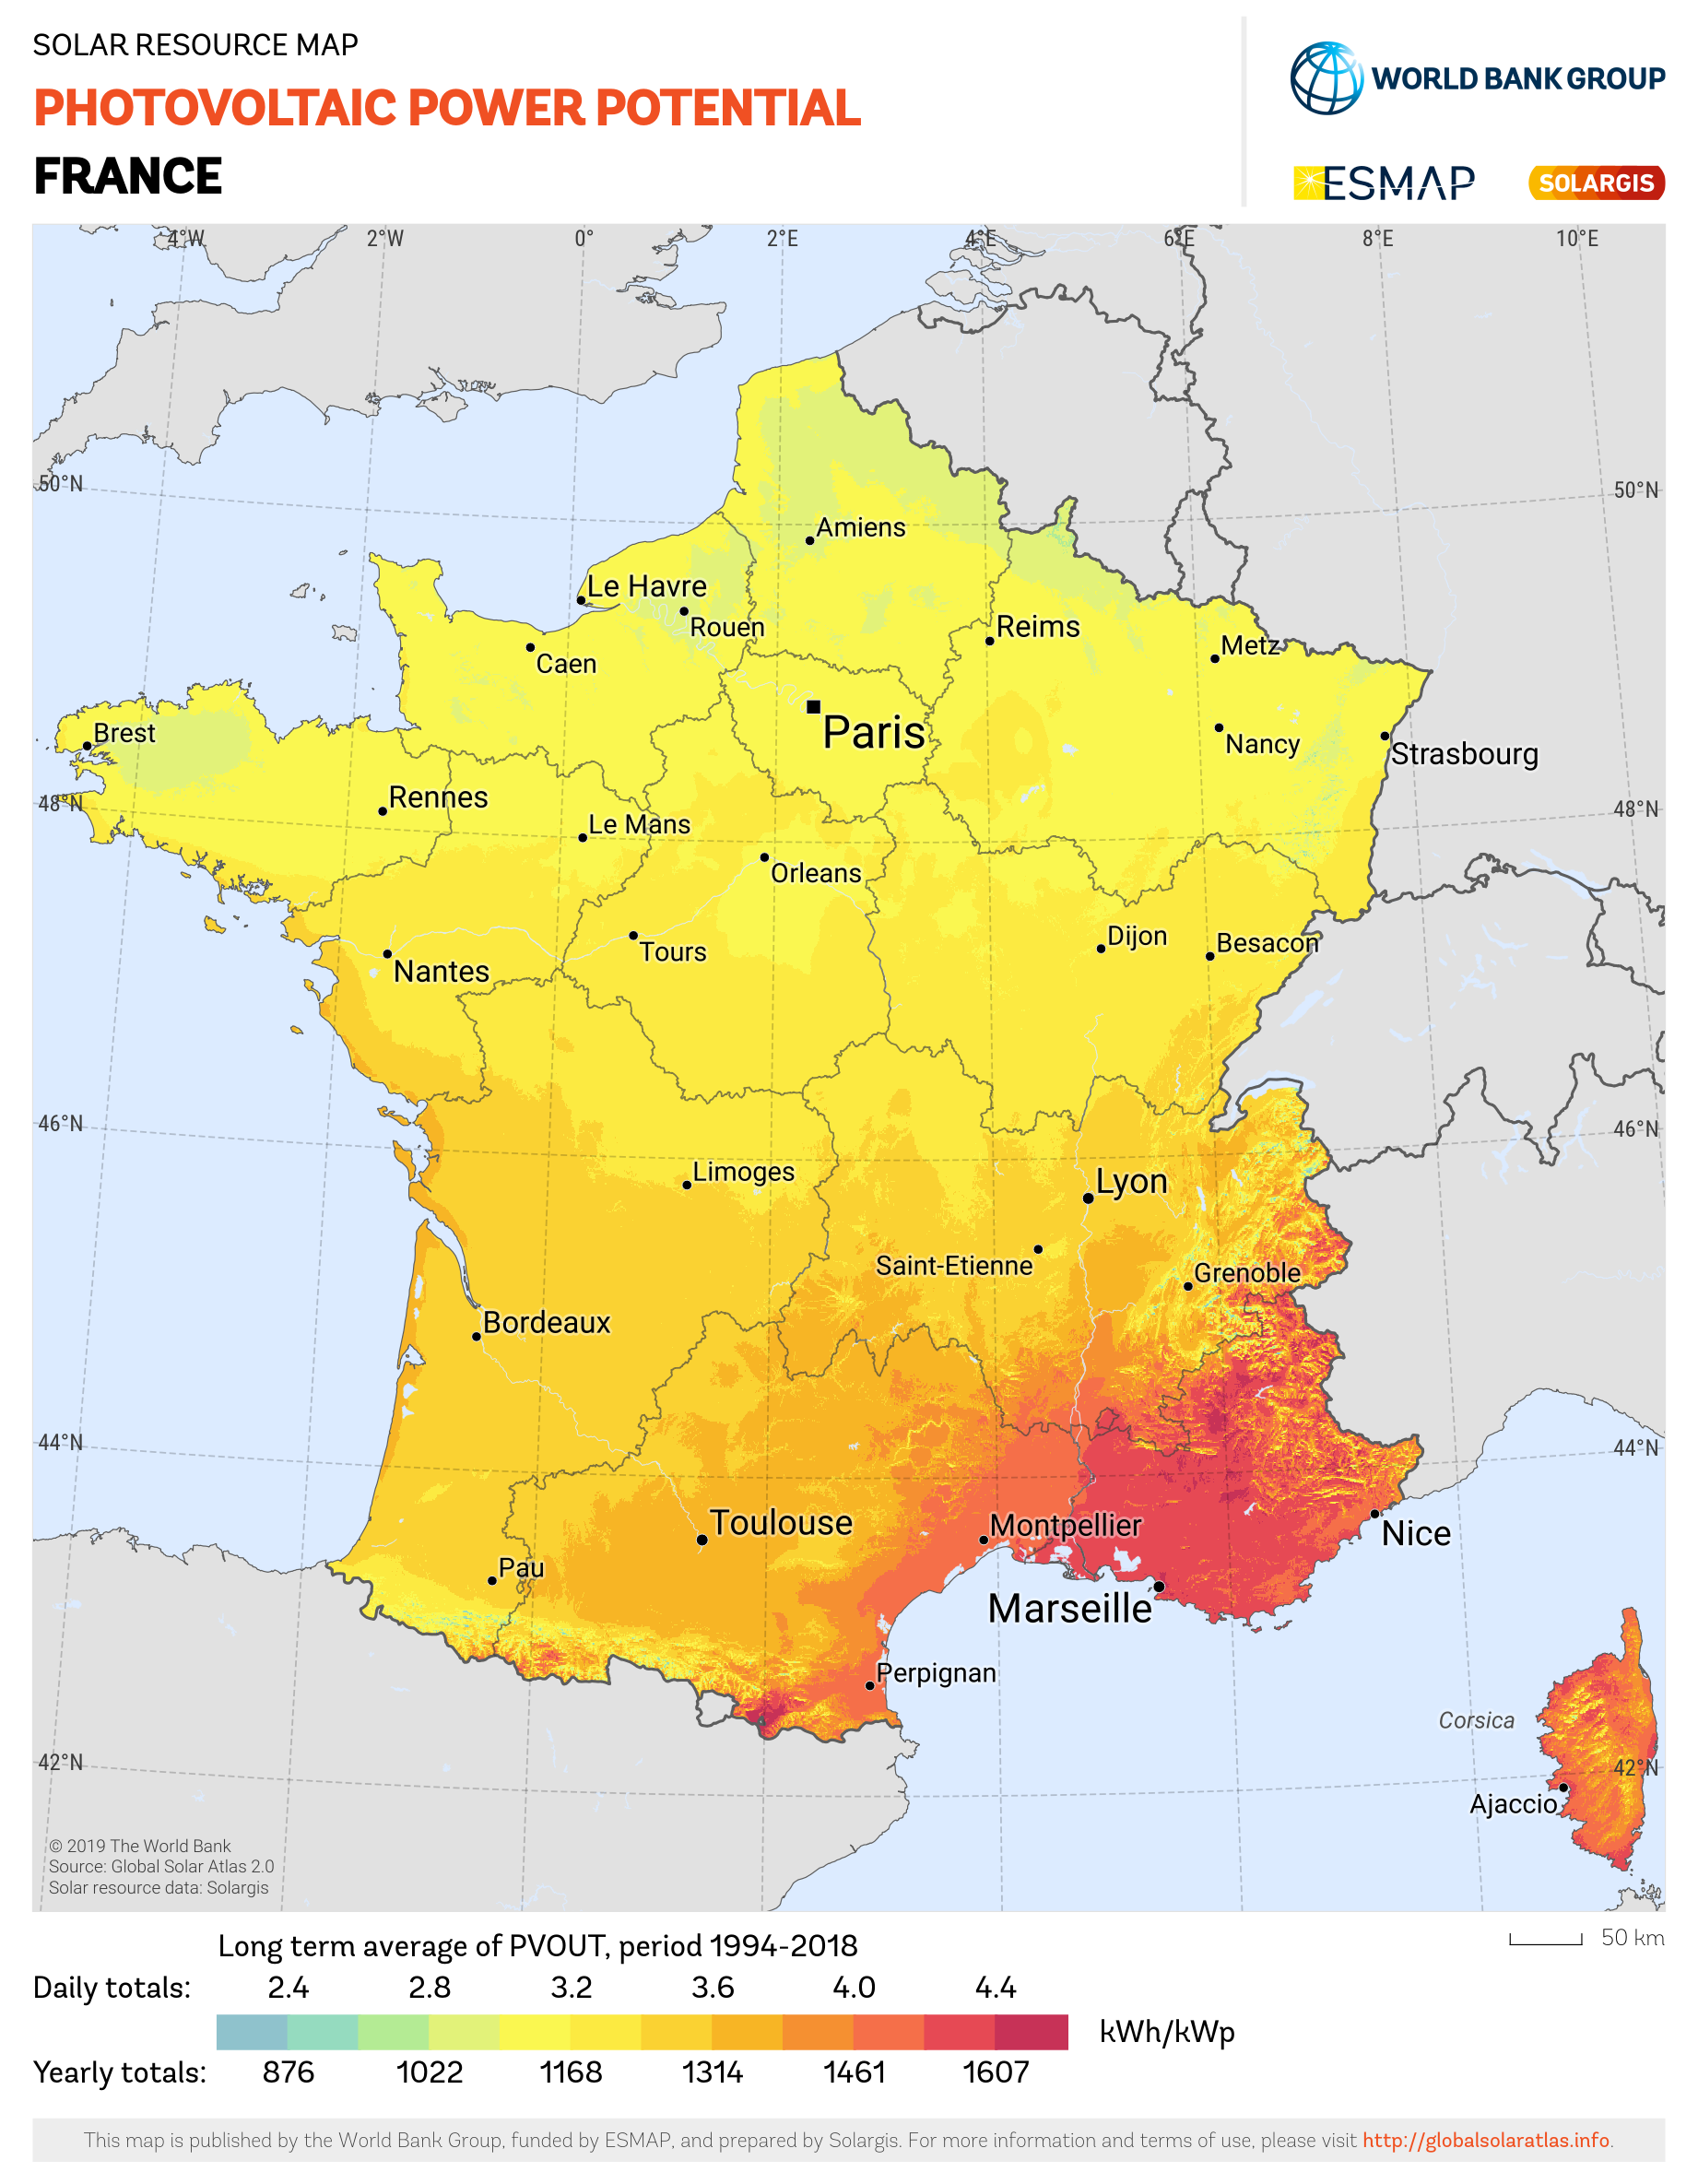

The data they offer is a ratio of production on nominal power in kWh/kWp.

The peak power capability (kWp or kiloWatt peak) is the amount of energy a panel can produce at its peak performance. It is calculated with a standardized test that all solar panel manufacturers must adhere to, with standardized radiance, temperature, and size:
- Solar radiation of 1000 W/m^2
- Temperature of 25°C
- Clear skies

In order to use all the filtering possibilities of ARLAS, we are going to use the monthly average, and create one entry in ARLAS per month, in order to utilize the timeline. We are going to see how to merge and crop all the monthly data to have a single GeoTiff that can be used afterwards. 

In [21]:
""" Get the path to all the files """
monthly_files = [get_absolute_local_path(f"sunny_osm/photovoltaic_potential/PVOUT_{f'0{i}' if i < 10 else i}.tif", local_data_path=LOCAL_DATA_PATH) for i in range(1, 13)]
lgdc_geojson_path = get_absolute_local_path("sunny_osm/languedoc-roussillon.json", local_data_path=LOCAL_DATA_PATH)
merged_tif_file = get_absolute_local_path("sunny_osm/merged_monthly.tif", local_data_path=LOCAL_DATA_PATH)

To load raster data and transform it, two tools are very useful in python: `rasterio` and `xarray`.

[Rasterio](https://rasterio.readthedocs.io/en/latest/intro.html) is a library that utilizes [GDAL](https://gdal.org/en/latest/) a very popular tool to process raster data to offer a wide varieties of tools and drivers to read, transform and write different formats of raster data.

On the other hand, [xarray](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html) is a powerful tool for handling grid-like dataset, and thus raster data with the help of [rioxarray](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html) which bridges the gap between the two tools.

In [ ]:
""" Load the GeoTiff data """

import xarray as xr
import rioxarray

def open_tiff(local_file_path: str, name: str = "data") -> xr.Dataset:
    """
    Open a GeoTiff and transform it into an xarray Dataset
    :param local_file_path: Local path to the GeoTiff
    :param name: Name given to the band data contained in the GeoTiff
    """
    tiff_path = get_absolute_local_path(local_file_path)
    tiff = rioxarray.open_rasterio(tiff_path) \
        .drop_vars("band").squeeze() \
        .to_dataset(name=name, promote_attrs=True)
    return tiff

monthly_tif = []
for i, path in enumerate(monthly_files):
    monthly_tif.append(open_tiff(path, f"potential_month_{i}"))
monthly_tif[0]

In [ ]:
monthly_tif[7].potential_month_7.plot()

In xarray we manipulate Datasets and DataArrays, for which there are dimensions, coordinates that can depend on multiple of those dimensions and data variables that are following a certain set of coordinates. As for Spark, the data is lazy loaded, and is not visible when unfolding the content of the variables by clicking the little cylinder icon.

The solar potential files are quite massive compared to the limited area of our study. In order to reduce the size of the aggregated GeoTiff, we are going to crop the rasters using a GeoJSON of the Languedoc-Roussillon region. A more effective crop would be using a GeoJSOn of Lozère, but keeping a larger region can help if we want to then add more data.

In [ ]:
""" Load the Languedoc-Rousssilon geojson """

import shapely
import json

with open(lgdc_geojson_path, 'r') as f:
    lgdc_polygon = shapely.from_geojson(json.dumps(json.load(f)))

lgdc_polygon

In [ ]:
""" Clip to keep only Languedoc-Roussillon and merge """

lgdc = xr.merge(monthly_tif) \
    .rio.clip([lgdc_polygon])
lgdc

In [ ]:
lgdc.potential_month_0.plot()

Now that the files are merged and cropped, we will write them to a single GeoTiff file to use in the data enrichment process.

In [28]:
lgdc.rio.to_raster(merged_tif_file)

With the monthly potential across a whole year, we will now be able to enrich our OSM data with the values of the raster. However, an important issue arises: raster data is grid data, and we have polygons in our OSM data. But a polygon is not necessarily contained in just one of the raster cell and can overlap multiple.

We would need to compute a weighted average of the photovoltaic potential of each cell the building is in, weighted by the surface of the building that is in the cell.

Thankfully, we won't have to write that method as the [exactextract](https://isciences.github.io/exactextract/index.html) library offers just this option! This tool supported by NASA, can compute various metrics based on geometric extraction, and is compatible with various tools we already used like `pandas` and `GDAL`.

To visualize what the library can offer, we are going to try it on Mende, the capital of Lozère.

In [ ]:
""" Test with a small geometry """
from exactextract import exact_extract

mende = "POLYGON ((3.433601853996702 44.5153261686079, 3.4334691068651457 44.515242968234354, 3.4333654284788153 44.51517675802465, 3.4331917107658407 44.51500099400172, 3.432985331048569 44.51483165952128, 3.4328116638521937 44.51466219638012, 3.4326986357751217 44.514524903688276, 3.432615685951229 44.514372188992546, 3.4325037930058557 44.51421868744859, 3.432388140108022 44.51406700100477, 3.4322904801937724 44.51396475686858, 3.432174072950925 44.51387879029275, 3.4319474275221777 44.51385537132194, 3.43166172686458 44.51384208548038, 3.4312288483322133 44.51383207482145, 3.430722889898216 44.51380794397538, 3.430335475070286 44.513820258215205, 3.4298570126646575 44.51393735296687, 3.429195773117713 44.514009244700894, 3.429366480899222 44.51428765331818, 3.429421257350633 44.5143765633978, 3.4294351659628375 44.51455115477626, 3.429463440965555 44.5147950083274, 3.4295662952443395 44.51508448359576, 3.4297232507009783 44.515373748156016, 3.42977487748924 44.51554459175276, 3.4298064426734935 44.51572451582379, 3.4298241272701597 44.51589909255237, 3.4298808080239973 44.516072617161825, 3.430004075779619 44.51623327903364, 3.4301968312135873 44.516431479815104, 3.430333817090963 44.51657588363655, 3.430383132563663 44.51660809980151, 3.4304099244688238 44.51665660802807, 3.430435513116318 44.51671232282598, 3.430466120789795 44.516766217571686, 3.430528031964812 44.51680018501562, 3.4306870079669114 44.51685808002785, 3.430852419347507 44.51693485463687, 3.431106315847227 44.51706529752302, 3.4311809675627236 44.517119920258374, 3.4312636564141537 44.51723842827275, 3.4313605018377347 44.51739829174614, 3.4314489460857738 44.517611301906534, 3.43154230689075 44.517808988782, 3.431644537656916 44.51801474303043, 3.431684250385113 44.51810731201413, 3.431688224475937 44.51813340331546, 3.4316509116839704 44.51819026413236, 3.4315987823098406 44.518284092562936, 3.431579180522413 44.51835348740066, 3.4315360783946898 44.51847608806351, 3.431543992112908 44.51852376963845, 3.4315822611394946 44.518592037945915, 3.4316710721083483 44.518688015892145, 3.4317914489197867 44.51879827405901, 3.431987107533037 44.519045073395255, 3.432086309312313 44.51918332147427, 3.432134013659159 44.51933347419876, 3.43227125949745 44.519510283339464, 3.432417127819551 44.519662752152236, 3.432442781826205 44.5197265684428, 3.4324006149258293 44.519806854725125, 3.4323249644741414 44.51995118897186, 3.432301960252222 44.52006921010495, 3.4323154933887907 44.520193389783586, 3.432372955177128 44.52030299359076, 3.4324807473640333 44.5204124001631, 3.432644620265387 44.52061521146684, 3.432751638028325 44.52078763742854, 3.4328878173154487 44.52098875651911, 3.4330463497323342 44.52115107755512, 3.433185939915089 44.521304470352, 3.433327695245652 44.52141194237572, 3.4335524422558343 44.52151188634878, 3.4338500528278377 44.521596239439816, 3.434147622778828 44.52167519046918, 3.4343647395182257 44.52176435997151, 3.4344895796926687 44.52179897785602, 3.4347111071386105 44.52180710793179, 3.434878514515268 44.521813650344164, 3.434915018652459 44.52181530698045, 3.4350885303054466 44.521797518602995, 3.4354381531184446 44.5217727336254, 3.4355438906527698 44.52177771783913, 3.435425292510028 44.52222650420041, 3.435890456509202 44.522498340430396, 3.4357575474184245 44.52272302451714, 3.4357149856681732 44.52291494326182, 3.435738147603125 44.523144412559596, 3.4357767429013513 44.52341703238166, 3.43578974973696 44.523471895565955, 3.435845587041428 44.52369583444891, 3.435871023380479 44.52389378646788, 3.435896633559424 44.52411424377652, 3.4358976685855773 44.52424837524431, 3.435921721967649 44.52443012846375, 3.435963935115865 44.52451908537205, 3.43592630190768 44.5246974812909, 3.4358965659108613 44.5249208579668, 3.4358752908825654 44.525099189293734, 3.435877806519332 44.52526212261893, 3.435888435031423 44.52549794328495, 3.4358632932243416 44.52582753011032, 3.4358753260359167 44.526082250314424, 3.43597194179103 44.52637174583161, 3.4362019829795107 44.52666521530527, 3.436353296448875 44.52686717115116, 3.4364555820000073 44.527075622362084, 3.4364261801970373 44.52717926618992, 3.436352942661938 44.52731009050766, 3.436370303396923 44.52743965641636, 3.436372820565777 44.52760258988996, 3.4363227901628934 44.5278053416611, 3.436141111517163 44.528071630479275, 3.4359080230760934 44.52836242853934, 3.4358480907220073 44.5284238815342, 3.4357020639371267 44.52841815634545, 3.4350749207858726 44.5283630146498, 3.434553604720827 44.52832275690971, 3.4341390414228363 44.52825416945769, 3.4334988544541045 44.52813875404718, 3.43289900175854 44.52803127892192, 3.4322324343284585 44.52792136109269, 3.4314170528656867 44.527769709714654, 3.4308359881632424 44.527649546638074, 3.430126375856342 44.527504674803396, 3.429557750116822 44.527364651292885, 3.4293737280816425 44.527326656985124, 3.429072558115906 44.527273813743655, 3.429025935501194 44.5272658928115, 3.4289906454009422 44.5272588280562, 3.4289137800280503 44.527245623174196, 3.4288003593951735 44.527224458098935, 3.4287745068608673 44.52730017863141, 3.428762257604368 44.52734433794199, 3.4288177711205146 44.527363027318586, 3.428888556472281 44.52740416331432, 3.429035167971691 44.52748731581964, 3.4292476552562405 44.527627827306155, 3.4294282109109164 44.52770634609757, 3.4295530748838 44.52774277007778, 3.4297362440522017 44.52783388155624, 3.4299243241677213 44.52790876929514, 3.4300896983282874 44.52797654327361, 3.4302011046081398 44.5280634323889, 3.4302503820356964 44.52808934727743, 3.430381326886355 44.52809783919691, 3.4305343717519365 44.528198969462764, 3.4306075390055613 44.528222090292665, 3.4308427690040806 44.52820856903942, 3.430969973277336 44.52822157606176, 3.4310932855257255 44.52821929406052, 3.43122965625665 44.52827907745768, 3.4313226494485294 44.52826160956552, 3.431400651440809 44.52825860402317, 3.431518042975185 44.528304957641524, 3.4316349875626395 44.52829279728954, 3.4317560858434586 44.52833013376236, 3.43184677545142 44.528340581876286, 3.4320556818880132 44.52834066461952, 3.4322649121133177 44.52838305697824, 3.4326907586070776 44.52844620579856, 3.4329262719262035 44.52846958883721, 3.4331279595767867 44.52851290938888, 3.4333195938628336 44.528558069520216, 3.4334720580231264 44.52858267762498, 3.4335437197966243 44.52857339378594, 3.4336797691263223 44.52859086415346, 3.4339132299166253 44.52867456924819, 3.4340227002142263 44.52867233838887, 3.434127254370516 44.52868543083938, 3.434358185489005 44.52876734446889, 3.4344981424302166 44.5288019030208, 3.434873448957164 44.528838235170944, 3.4350663025823445 44.52887798604, 3.435212850703302 44.5289512280475, 3.4353112383076914 44.52898054802118, 3.4353918204214877 44.52898563164928, 3.4355135494888214 44.52894103966081, 3.435622520365768 44.528873991878775, 3.435730246431705 44.52880874938456, 3.435869599959129 44.52876498767185, 3.43601808894635 44.528763500994735, 3.4363908723590284 44.52879893771391, 3.43665200984804 44.52888072714113, 3.4368974618665584 44.52888695784029, 3.437135098543714 44.52885900980604, 3.4372734993010843 44.52885486066993, 3.4375192929484433 44.52890520041737, 3.43775146739935 44.52898440132865, 3.437961885949301 44.52901687556761, 3.438274078235173 44.52902823983198, 3.4385797617316203 44.52901172161571, 3.437284539480191 44.52995581128987, 3.4366687538177483 44.530069878830005, 3.43592851591851 44.530202439296254, 3.4357764630338172 44.53023184737594, 3.435505375580606 44.5303292430036, 3.43523024123252 44.53039154452559, 3.4346357923248703 44.530499214896004, 3.4344686639114146 44.53053228149304, 3.4344173085744454 44.530563992042026, 3.4343612030900674 44.53063263113784, 3.4343618953709854 44.53072265251153, 3.434395252900664 44.53080534342114, 3.434411793229517 44.53082868459736, 3.434449970195594 44.53088344905538, 3.4345475732361788 44.530973989226915, 3.4348954530565208 44.531205781690105, 3.4352229569539667 44.53140614498176, 3.435437308901218 44.53162135758485, 3.4356770131958627 44.531859876020405, 3.4358369885304194 44.5320410933172, 3.4359422094193888 44.532139704413865, 3.4368826793824447 44.53315866115264, 3.437561885643979 44.53521572588903, 3.4377948968739656 44.53621137117737, 3.438294803542364 44.536889071392764, 3.4390119503290695 44.537823375685896, 3.4390799531354443 44.53798965038663, 3.4391502860001704 44.538293653138744, 3.4392498154843074 44.53879109225097, 3.439290206509252 44.53896737943786, 3.4392032884626036 44.53895872280461, 3.4368856833509516 44.538753660229986, 3.436935516430326 44.538849789146425, 3.4369891953371665 44.53895490526503, 3.4369908183533178 44.539164655759045, 3.43691877146396 44.53945121861719, 3.4367908404115513 44.53967318496238, 3.436634897047111 44.53985385071415, 3.4365299257994315 44.53995239246941, 3.4364462406274434 44.54003644606872, 3.435847060636224 44.541174922011216, 3.435603914380504 44.54163770731914, 3.435588224468647 44.54172509300296, 3.435466199579614 44.54206136583153, 3.435254608135754 44.54237278481927, 3.4349578769599525 44.54274395507596, 3.4346863839682995 44.54296018297004, 3.4344238248835963 44.5431925794785, 3.4343343157072064 44.54333877142699, 3.4342249911176324 44.54352735279271, 3.434172753574008 44.54377332532803, 3.43404564555172 44.54394127081647, 3.4338606258722413 44.54410854349722, 3.4336617930171838 44.544280371359264, 3.433627424928335 44.54439483758636, 3.433632010099034 44.54450014837045, 3.4333789917177318 44.54548511094424, 3.4323975980173858 44.54670249098466, 3.43187337881489 44.54696291344165, 3.429673944464692 44.549422867287305, 3.4293582017926103 44.54995254088082, 3.4295400890785315 44.55019670093682, 3.4296783060869034 44.55049234479977, 3.4295647612745976 44.551122960293206, 3.428244444529655 44.55399087956749, 3.4282245189705556 44.554019764812686, 3.428916959572934 44.55517569871459, 3.429212811597983 44.55566878643217, 3.430006171566302 44.55568730613113, 3.4308625047198373 44.55570827521056, 3.4321243463364013 44.55574025517163, 3.432268288357911 44.5556289610723, 3.4322933243922438 44.555609957819364, 3.4324636572422964 44.55549225840849, 3.4326706531302964 44.555394220603276, 3.432824486010335 44.55525948053401, 3.4330117181422173 44.5550471878023, 3.4330379229331625 44.55501647655085, 3.4331989212371465 44.554831293880426, 3.433329023433833 44.55472185321147, 3.43343772184592 44.55461249640204, 3.43359025718483 44.55447325913749, 3.433668869728925 44.554381124975464, 3.43376996435975 44.55426549596093, 3.4339101154404226 44.55415331440235, 3.4340025137830814 44.5540530235958, 3.4341487927470475 44.553919211665914, 3.434293777396872 44.55378090338914, 3.434447387270935 44.55361825425721, 3.4345571671658384 44.55348638588647, 3.4346772772728076 44.55355163138834, 3.435033818395416 44.5537455815552, 3.4351514116076727 44.55381083646772, 3.4355644384814297 44.55561420944248, 3.4363309851606694 44.5562359573016, 3.437158197376549 44.55672242230944, 3.437915906813894 44.556849956739754, 3.438857296238782 44.55679580577866, 3.4394326704236233 44.55646762699235, 3.439950763953301 44.556706831513075, 3.4403761423932164 44.556842874512476, 3.4408456535490903 44.556986841988724, 3.441318072277055 44.55718030968828, 3.4417323512899975 44.55734519991506, 3.442041699092135 44.5574555933197, 3.4423378188964073 44.55764526098313, 3.4425514336779117 44.55791087965695, 3.44279978741514 44.55827088511174, 3.4430842061910676 44.558573129264566, 3.44314875261092 44.55861518212708, 3.443432241629422 44.5587985959022, 3.4438187674443506 44.55895458739165, 3.4440770271053767 44.558971554288185, 3.4443444337302536 44.55903079563156, 3.444552464008421 44.559065068289804, 3.444807181114116 44.55911175606528, 3.4452254915336744 44.55914608059909, 3.4456539677828655 44.559192065810215, 3.446028181723726 44.559222964229534, 3.4462766336313897 44.55927327493866, 3.446526494628596 44.559342484695286, 3.4468382456148956 44.55943575032339, 3.447170542943251 44.55957934603271, 3.447404672689545 44.55972873999586, 3.4476414789796115 44.55989792818758, 3.4477636052733427 44.56005497735101, 3.447996529428678 44.56021067676045, 3.4481481764946054 44.560279380992924, 3.4484312038564355 44.560401566834024, 3.4487712590248485 44.560569433155514, 3.4490555340184548 44.56068981184688, 3.4492641034155658 44.56079069222835, 3.4495074998184077 44.560837415293264, 3.449699500748137 44.560913155206435, 3.4498488630111206 44.5610106745463, 3.449980819995795 44.561136172457154, 3.450073123103936 44.56134195436847, 3.4500983176604376 44.56150119655002, 3.4500992650969637 44.56162002614613, 3.4500977659651704 44.56174786825378, 3.450061490729567 44.561936169074016, 3.4499996010387584 44.56207055904175, 3.449920240317708 44.562224825734006, 3.4497983249857938 44.56241167482445, 3.4497057187127864 44.56248407222639, 3.449565019146401 44.56252605669165, 3.4493942205804564 44.562583467763986, 3.4492826897671076 44.56265144054312, 3.4492066955453065 44.56275437858397, 3.449169850820656 44.5628715614322, 3.4491155418436117 44.56300952112946, 3.449044282894555 44.563074629149106, 3.4489660055258713 44.56320728470209, 3.448925403854953 44.5633271835209, 3.4487942890332297 44.56346635548853, 3.4487838721932844 44.56358163033998, 3.448791284754131 44.56372203986768, 3.4487280306764307 44.56384383118544, 3.448676180891057 44.56397457868811, 3.4486747929565307 44.5641168245031, 3.448724961896341 44.564249858336765, 3.4487163192247636 44.564429944327614, 3.448736309788721 44.56456850229879, 3.4487656518843592 44.56477454137062, 3.4487506700944373 44.564949251630644, 3.448690076161354 44.56508903726718, 3.448659603803129 44.565216096961514, 3.448654187607097 44.56532685029407, 3.448658945613482 44.56545016587149, 3.448660119050001 44.5655978028964, 3.448740611775783 44.565743317198766, 3.448866638951306 44.56591385355744, 3.448982470995096 44.5660691268937, 3.449106624394629 44.56616224868492, 3.4492359514261604 44.566272454147516, 3.4493319520654637 44.56646741903135, 3.4494648525073104 44.56670994723497, 3.4499678174005557 44.56771978664816, 3.4500369735468936 44.568653970521424, 3.4495076545815415 44.57050345188023, 3.4490093145704024 44.5713436177568, 3.448868477854478 44.57137119784, 3.4486824747258087 44.57142056737577, 3.4485682994941973 44.571475046489475, 3.4484228108797224 44.57155125877208, 3.4483589536928037 44.571598331341136, 3.4483152681720783 44.571648022781424, 3.4482341295448258 44.571739278009574, 3.4481785074584996 44.57187184148524, 3.448159565056272 44.57202406179342, 3.4481552337058736 44.57227165009989, 3.4481366256168893 44.57262462646117, 3.4493118787216916 44.57343818667795, 3.4495465208230334 44.573485845983306, 3.4498042349532247 44.57358382528998, 3.4500758181797595 44.57368354801384, 3.450226424062446 44.5737747606176, 3.4504325106477847 44.573873849138046, 3.4506211094503976 44.57399101377832, 3.4508583160201445 44.57420160657904, 3.4510724224587364 44.57435827772711, 3.451201584992701 44.57444507530421, 3.451349323049983 44.57449218547815, 3.4514216089953975 44.57455400793841, 3.4515785094816027 44.57464429276897, 3.451747774530098 44.57470571855213, 3.4519206885911147 44.57475092450006, 3.452197528206805 44.57487672808558, 3.452349400171119 44.57496793268365, 3.452464581979346 44.57503858141139, 3.4526911102751394 44.5751726921637, 3.452937892413652 44.575319323045456, 3.453100117227701 44.57544469402216, 3.453285215886778 44.57559517816408, 3.453380581054645 44.575707319180246, 3.4534797250647835 44.57581944460907, 3.4541464466076284 44.57524684193606, 3.4546558596455026 44.574691987762066, 3.4547001486666393 44.574561267987576, 3.454719721947693 44.57417677706218, 3.454695134700818 44.57378256512641, 3.454682429052881 44.57361246862157, 3.4546635133308574 44.573453200784066, 3.454574330577534 44.57332663141352, 3.454453089863651 44.57312907348473, 3.4543648631432013 44.572964689199864, 3.4543068920087263 44.57280378146437, 3.454251887992952 44.57254203263846, 3.4543099428375617 44.57240045343103, 3.454393705727803 44.57216694217533, 3.454355704602613 44.57198344593436, 3.454240424017014 44.5717435512787, 3.4541358424579203 44.57158103468056, 3.454051976597804 44.571488652922184, 3.45399492746961 44.57144207401867, 3.4539150356813972 44.57137398277755, 3.4537589295195756 44.57122518142274, 3.4536784449823585 44.57108327136336, 3.453674298166248 44.57088073053574, 3.4537364494730634 44.5706221014841, 3.453902794577502 44.57032163250949, 3.4540405709513085 44.570070794871384, 3.4541957742238547 44.569794678238374, 3.4543290033489154 44.569605076435, 3.4544742687700976 44.56950274985563, 3.4546381555461587 44.5693670369513, 3.454861604837567 44.56912124725254, 3.455069326798103 44.568955644739624, 3.4551964431113 44.56878947378519, 3.455340118740431 44.568646641098816, 3.4556180762932787 44.568445638024016, 3.4558652395878724 44.56833028570016, 3.4561728273028316 44.5682119825309, 3.456259036224528 44.5681270023796, 3.4563027047496084 44.56807640764292, 3.456500009454552 44.568025178051464, 3.456738863826699 44.56797287605295, 3.4568361503223035 44.567856340680926, 3.456944398517719 44.567693846816276, 3.4570111692810084 44.567541427289356, 3.4570492965210904 44.56742873752181, 3.457154224713268 44.56732297334122, 3.457185320720648 44.56727513106827, 3.457234778848297 44.56700665006629, 3.457288765525744 44.566830876674075, 3.457343318245366 44.566569576622705, 3.4573410061475123 44.56628420513138, 3.457310256006847 44.5660637698195, 3.457202362839175 44.565803142367585, 3.4570985035811455 44.56557400708691, 3.4570379627130285 44.56540681011415, 3.457034547699268 44.56529609284177, 3.457109330136145 44.565200356320965, 3.457253035542609 44.56506292270531, 3.4574324440816175 44.56498025661719, 3.457624729153897 44.56493264684141, 3.457829964097787 44.564929095558185, 3.458071702489831 44.56492359200068, 3.458240207365951 44.564894084875476, 3.4585050522456244 44.564787655918586, 3.458557165212536 44.56469201252686, 3.4586755494162147 44.56453847759875, 3.458697411001073 44.564439358749965, 3.4586750311807513 44.564319717766416, 3.4586688166124078 44.56417480251669, 3.458692706419303 44.564015358179354, 3.4587131841909384 44.56390094076133, 3.4587182952186875 44.56375507824686, 3.458651711428854 44.563619416285086, 3.4586126843533305 44.56346563477894, 3.4585928235166064 44.563345983369146, 3.458558701984838 44.56317597691114, 3.4585236870613483 44.563050986891916, 3.45852482347786 44.56288083406744, 3.4585388589519375 44.562748438390194, 3.4586033790817474 44.562630237177046, 3.4587410782934223 44.56252973709565, 3.458881522241037 44.562457133326305, 3.459156413328518 44.562348860612154, 3.45939988968843 44.56224882017574, 3.459605728974658 44.56216604066142, 3.4598251326691485 44.56204809437443, 3.4600105670026835 44.561933890158286, 3.460154330410262 44.5618054551876, 3.460285501447529 44.561677072513376, 3.460425214407331 44.56151534467562, 3.4605597870883877 44.56134103454663, 3.460693143856853 44.56117213085859, 3.460873118016219 44.56100663351468, 3.4610435178321417 44.560902393119456, 3.4612529213071475 44.56079438856198, 3.461433437126217 44.56069550684356, 3.4616505853734214 44.56061087577774, 3.4618578881159756 44.560554193327626, 3.4620435344666394 44.56046699245894, 3.4620597928225205 44.560453420632925, 3.4622073178512847 44.56032406704115, 3.462363110574735 44.5601280598665, 3.4625503215213604 44.55992471887417, 3.462740998588586 44.5596835524014, 3.4629130972316022 44.55948027413731, 3.463058937758848 44.55929961205192, 3.4631937333799296 44.559154105990594, 3.4633397864288975 44.55899955000811, 3.463498488886672 44.55885214277926, 3.4636862312631522 44.5587145161933, 3.4639057905548647 44.55861816730023, 3.4641242306116076 44.55853892748712, 3.464351676266571 44.558483055962654, 3.464566323064388 44.55840203071713, 3.464850841177549 44.558243289203844, 3.4649469907614376 44.55814565711264, 3.46503014869018 44.557999465975485, 3.4650353021850218 44.5578608052958, 3.4650284417168233 44.5576393719341, 3.4650412816042633 44.55736384046319, 3.4650197423970295 44.557194683620196, 3.4649551207131855 44.556992398824185, 3.4649559781400274 44.556790738603794, 3.4650333266482267 44.55655094572267, 3.465155327241125 44.55638208469318, 3.46554563657074 44.55653348296633, 3.4669480420421612 44.55741881255996, 3.467391818543782 44.55763929783638, 3.4692417807577325 44.558888206932004, 3.469449412397574 44.55902416312505, 3.4697996546068417 44.559199123560035, 3.4699531243077453 44.5591813657935, 3.4700638289879846 44.55916919136312, 3.4701568535381186 44.55915079031139, 3.470221270818369 44.55917482291898, 3.4704042100231587 44.55921815631775, 3.4705303016774454 44.55923922527705, 3.4706688870248055 44.55924853754745, 3.4708501847785413 44.55924596425265, 3.4710288891730805 44.559234399180816, 3.4711861509573643 44.5592184240342, 3.471274198880714 44.559207245303924, 3.4713673809432555 44.55920774789291, 3.471482933875219 44.559173044995944, 3.4716449761098125 44.55912644015063, 3.471814550181971 44.55907710212886, 3.47197651660659 44.55902149458058, 3.4720933354213392 44.558987685888525, 3.472068465861471 44.558724017792045, 3.4719313834630827 44.55814123921452, 3.4729942594684697 44.55786031431643, 3.472916089374191 44.55709633387557, 3.473770671816397 44.556603833517656, 3.4735202101628877 44.55601524193689, 3.4744871742246817 44.55586345009294, 3.4745398420675246 44.55583801670751, 3.4746152860893527 44.55582598920902, 3.474846616260675 44.55578538364821, 3.4752989911078958 44.55567900825523, 3.475716308514579 44.55559618860579, 3.4758872564545746 44.55556214272355, 3.476020585000571 44.55554626379848, 3.476039630674361 44.55451989351843, 3.4760343062054297 44.55448570687179, 3.476032637327569 44.55443710042637, 3.476055518592459 44.55431366719184, 3.476106280017461 44.55421171982139, 3.476193316925749 44.55408170818689, 3.4763565598705215 44.55388114810538, 3.476467106329223 44.55370242122803, 3.4765275964746514 44.55355992035468, 3.4765505750794654 44.55344818991492, 3.4765522192486586 44.55334465381408, 3.476536169282479 44.553233091804735, 3.476477782968639 44.553028086259644, 3.4764589342108563 44.55288322700553, 3.476437240964551 44.55269966919517, 3.476439650522284 44.552537613452415, 3.476447430161919 44.55241514563218, 3.4764585861104904 44.55239439170628, 3.4765023611182895 44.55235999325404, 3.4765074381284142 44.5520664892656, 3.4765223216076446 44.55129400918049, 3.476906676827937 44.5495485634343, 3.4775807972010626 44.54961766997889, 3.4775530483718637 44.54916496383299, 3.478730347459852 44.54903923237282, 3.47884728817009 44.549319603573636, 3.478946124369836 44.54954333740447, 3.479047372235199 44.5497544571937, 3.4791290268092574 44.549881938575346, 3.479209461043381 44.5500139264566, 3.4793527516764065 44.55028337988435, 3.4804626020169973 44.55021823959469, 3.480989812318987 44.5509226418224, 3.4804505407031026 44.55116805739673, 3.4806181837637777 44.551339275950184, 3.481403930959361 44.55106037624097, 3.481402526561628 44.55074799504598, 3.4812870204743294 44.550637767598374, 3.4811797902673027 44.55046448637195, 3.481111633129407 44.55029643633287, 3.481056004161032 44.55012112967692, 3.4810066854159625 44.54994759602238, 3.480952385032847 44.54978038581564, 3.4808793701306864 44.549633062621055, 3.4808280405115615 44.54951895425364, 3.4807758354582945 44.54944986223247, 3.480724912421073 44.54938346536098, 3.4806349714506855 44.5493181385594, 3.4805464504706607 44.549271710777916, 3.480492126555448 44.54924944090261, 3.480324226712564 44.54919525606844, 3.4801601574491117 44.549147356081015, 3.4800249128148297 44.5490840262849, 3.4799222006223047 44.54899714841475, 3.479833160531746 44.54888950527476, 3.4797883346430876 44.54879967497908, 3.479687185138422 44.54860025877899, 3.4795935972366867 44.548401709913996, 3.47956248973051 44.54829651570435, 3.4795529818954347 44.548214634199276, 3.47955680938605 44.54807237800011, 3.4795622779976454 44.54797512720221, 3.4795552573601327 44.5478896339047, 3.4795158350982405 44.5478429920899, 3.479439860092257 44.547791107477714, 3.4793234030533213 44.54771599204419, 3.479232283905728 44.54765967178081, 3.479163778512909 44.5475978518127, 3.479118992906596 44.54751252237852, 3.4780867377283244 44.54781497943182, 3.478027594132933 44.547817936242595, 3.4773808288136308 44.547854943829925, 3.477073061963115 44.54763571268987, 3.477175116683134 44.54749663319266, 3.477299594321798 44.54732954893213, 3.4781129075308437 44.54674266829601, 3.478340322330731 44.5466903691022, 3.4787574772566754 44.54659673566555, 3.4807632970510025 44.546646536667836, 3.4805732784235452 44.54591546071874, 3.47890681965258 44.54520610264061, 3.480035027804518 44.5446466498572, 3.4817947238115394 44.54462818236275, 3.48385946615918 44.543482138626246, 3.48353832415629 44.54317115912046, 3.4817483876145663 44.54170527673958, 3.4814353643419014 44.541753455035014, 3.479989861333086 44.5424430371434, 3.4794230763537075 44.54240408828896, 3.478283063988789 44.54201112291126, 3.478196681228141 44.54132370762616, 3.478505037066894 44.54027898458232, 3.4781652692989913 44.53984383666298, 3.4780252977846664 44.53966529359278, 3.478006205690253 44.53949162854872, 3.479715237215906 44.53960304849737, 3.4792657195085015 44.53884339169828, 3.4802787473797525 44.53748411795717, 3.480643414073087 44.53685145814929, 3.4810709873631427 44.536216722669515, 3.481038705563957 44.534643233599645, 3.481512739513963 44.53370311128492, 3.4822127177847926 44.534021443470024, 3.4834906745582246 44.533048090075965, 3.48430084405026 44.53315346839919, 3.4846190461619746 44.53136778654563, 3.485076285702006 44.53112001148928, 3.485155419898837 44.530223020352075, 3.4845407774773873 44.530019564148716, 3.4849706808177507 44.52952074155152, 3.4852186789472186 44.52938281463002, 3.4862107709513537 44.52869786489216, 3.4870999635812865 44.528633628297996, 3.4871414445597226 44.52877388326636, 3.4872075887267258 44.52914719253651, 3.4873775949613623 44.52945162475049, 3.4875814881280465 44.52974510414261, 3.4877617369125478 44.53006929598986, 3.4878511989806187 44.53037318324272, 3.4880540883704687 44.53069547416236, 3.488229293395587 44.53101788721057, 3.488335646759395 44.53123707648892, 3.488439411392953 44.53173895404963, 3.488573991373745 44.53202013518654, 3.488813356573098 44.53233866255159, 3.4889989702560573 44.53255389935459, 3.4891180160891913 44.532784735011376, 3.4892089432192117 44.53311112120676, 3.4893007555972297 44.533394291660436, 3.4894296387563397 44.533598076099594, 3.4896645530088555 44.533837399976434, 3.4898669981955694 44.533960735745886, 3.4900765815918042 44.53403632642923, 3.490286704756633 44.53417403129705, 3.49026752857451 44.53442978634575, 3.490231482405881 44.53477203997167, 3.490225751030188 44.53512676246884, 3.490151899754067 44.53546378255753, 3.4900352398516716 44.53579919217699, 3.4899687038610536 44.53610917235493, 3.489933655709192 44.536421713534665, 3.4901496194914676 44.5365062783509, 3.491128429958981 44.53689173520484, 3.4931517678564457 44.53768843688549, 3.4947234712508495 44.5380748132307, 3.495878604665047 44.53860887939206, 3.496655146977109 44.53917254515118, 3.497202303731936 44.53927181044199, 3.4983543833844357 44.53959700724239, 3.4987957045708313 44.53982637818446, 3.4988430878940813 44.54034560768487, 3.4988546694634386 44.54094422097714, 3.499563902494788 44.54086449295024, 3.5009622552912325 44.540708715471254, 3.5009977016796334 44.54087330024429, 3.501014687779932 44.540943442610114, 3.501015489609875 44.541175703307914, 3.501031907196614 44.541465509132806, 3.501085607387506 44.541701130812854, 3.5011947000258616 44.541937401302945, 3.5012584152724346 44.542166675738194, 3.5013118173174274 44.542510328726536, 3.5014239575167645 44.54280600174563, 3.5015398351745004 44.54309715646416, 3.501577714304978 44.543251827425024, 3.501701237323953 44.54341151075762, 3.5019088796098763 44.54368784415791, 3.502114254522717 44.54399209528629, 3.502748572000894 44.54397750555931, 3.503752928083373 44.5439567232586, 3.5038471191345213 44.543931986705786, 3.504034258288898 44.543884319534115, 3.505900613546521 44.543409453922145, 3.506364062671765 44.54329209735705, 3.5078812325934736 44.54290612339505, 3.5079032703912363 44.54269716389987, 3.509830311245648 44.54295655705545, 3.5101386804305177 44.54295243194446, 3.510401946151264 44.54297192100471, 3.510632403151053 44.54298255867128, 3.5108492338648296 44.54301756567655, 3.511103016758882 44.54310191500464, 3.5113242358234142 44.543204419586, 3.511558222670137 44.54332667009838, 3.5117449348203302 44.54337171766156, 3.5119790965252733 44.54337423309739, 3.5123109922267157 44.54332678078244, 3.512601381100378 44.543283121183094, 3.512959586944044 44.54322204099679, 3.5132712835896744 44.54316837787452, 3.5134849770329004 44.54313497522058, 3.513667927913889 44.543043198864126, 3.5138732899241694 44.54292431037074, 3.514062947901081 44.542739776295505, 3.5142683079763146 44.54262088708236, 3.5144045021579675 44.54250952176691, 3.5145291949285835 44.54237930461784, 3.5145864569415144 44.54230881818419, 3.5147145442603303 44.54227491184763, 3.514876838821277 44.542265152618704, 3.5150423101696093 44.542189660021236, 3.515140244885078 44.5421621955998, 3.5152293930319787 44.54213747284734, 3.515444052559821 44.54207255310581, 3.515700561995389 44.542041647010024, 3.5159741833760423 44.541954844798774, 3.5161511207459064 44.54189460121626, 3.5164177070128493 44.54186454659275, 3.51666504151429 44.54179407013105, 3.516850319064143 44.54168247210313, 3.5170355793976595 44.54156907334518, 3.517218986636477 44.54139086490947, 3.5174318461865908 44.54126743343859, 3.517596613549208 44.54125315735777, 3.517764137603297 44.54126497537242, 3.5177493342485446 44.541435192176614, 3.517716128695724 44.54165770982932, 3.5177310805305946 44.5417782733298, 3.517783464017568 44.54186265126037, 3.517880043415665 44.54196212613927, 3.517999057316426 44.54203718890983, 3.518113020096337 44.54211047475738, 3.518214048901457 44.542146010654804, 3.5183506941457385 44.54222189055107, 3.518440807930549 44.54230249004319, 3.5185030207762438 44.54249755239612, 3.5185809837751494 44.54276276035611, 3.518646926274493 44.54281556543948, 3.5186519943275596 44.542819142637576, 3.518677351139305 44.54283882904971, 3.518747964946528 44.542852001071225, 3.5188788000938938 44.54284328401733, 3.519047381022353 44.542832588865274, 3.519320917913016 44.54287361441681, 3.519520056594965 44.54290058536716, 3.5195579680913944 44.54291661149836, 3.519681847257586 44.54297274432932, 3.519932107254253 44.543083197298095, 3.5201212930338244 44.5431228175615, 3.5203226518741166 44.54311736755799, 3.5206333145818633 44.543088895535696, 3.5209645488381813 44.543107138657135, 3.5212926053814178 44.543190213907806, 3.5216095918643116 44.54330124829292, 3.5218247782294245 44.54342986773851, 3.5219024610541223 44.543526727761446, 3.522003076488466 44.543653187628266, 3.5220865690160323 44.54383374349678, 3.5222083996411593 44.54407623539068, 3.5222948856018483 44.54430809135346, 3.5223640421099787 44.54443560000345, 3.5225645548328277 44.54447426229146, 3.5226832302898887 44.54451151115206, 3.522791910643711 44.54455690948297, 3.5228893204608016 44.54460866284977, 3.5229743426886273 44.5446820808634, 3.5230986544202842 44.54478412075859, 3.523226200795821 44.544827628784496, 3.5234065831970676 44.54486728520285, 3.523623395673886 44.54489866629699, 3.523899104347454 44.544900959447766, 3.5241720113472597 44.54487265662555, 3.52452921518633 44.544839451437944, 3.524790516388633 44.544781493885466, 3.52500764233031 44.544711142237446, 3.525244598481681 44.54460738648767, 3.525422860064132 44.54455432369385, 3.5255495615131602 44.544506907557505, 3.5257506565599295 44.54447264084913, 3.525861563459192 44.544486516729926, 3.525927103953033 44.54449520708674, 3.5260293923383834 44.54452982965924, 3.5261736568873663 44.5446110652409, 3.526271371926869 44.54469522327895, 3.5262993588830396 44.54472659872005, 3.5263632128762517 44.54482442187001, 3.5264043752774885 44.54491875216327, 3.526433931727339 44.54498342944155, 3.52650633760959 44.54505330391217, 3.526582201058599 44.54508895224329, 3.526681822195446 44.54510738239737, 3.526825635632493 44.545140005658126, 3.5269606712601744 44.54517627163727, 3.5270783023609127 44.5452360271112, 3.5271633225754817 44.54530854170536, 3.527216822539802 44.54537580522982, 3.527265741326717 44.5454917042672, 3.5272815530742885 44.54556725001035, 3.527864145917984 44.54527008360119, 3.5283791500300343 44.54514968715472, 3.52969366371503 44.54491022329306, 3.530379651853123 44.544633253339725, 3.5316168819652987 44.54367483579557, 3.5318687102052517 44.54341435023922, 3.5319248200622657 44.5433573640237, 3.532543201043114 44.5428556432469, 3.533837733184629 44.54104258562999, 3.534489368077753 44.540068961601996, 3.5343857557575395 44.54002715134136, 3.5342686795858027 44.5398926802425, 3.534147938634156 44.5397699300281, 3.534045015426151 44.539667799283905, 3.5339397965390056 44.539589086085506, 3.533858782011627 44.53954086429493, 3.5337059468869456 44.539484887400405, 3.5334914968503415 44.53943550980886, 3.533381882171162 44.53942433617051, 3.5332622661951274 44.53942041274096, 3.5331250543784205 44.5394192749052, 3.532982892854268 44.53942716330572, 3.5328216898901865 44.53941803864991, 3.5326957126957756 44.539406943297884, 3.532476305561978 44.53936568991939, 3.5321824762726606 44.53930769010432, 3.5320174214578985 44.53929048058501, 3.5318539984363753 44.53931287400283, 3.5316858118273062 44.53936409815171, 3.5314775593307415 44.539438021202976, 3.531415918450542 44.53944191892717, 3.5313818835720654 44.53943668123963, 3.5313646653970676 44.539345838759616, 3.53130950623701 44.539102136219995, 3.531266976452927 44.53886287416053, 3.531284659004452 44.538601716350406, 3.5313566409595647 44.5383592025001, 3.5314577488977426 44.538135453679914, 3.531645244206943 44.537862675284444, 3.531822156046691 44.53766916961, 3.53194126319974 44.53748584495285, 3.5319653927340635 44.537374997896926, 3.531946924107537 44.53728506185964, 3.531936380323256 44.53723469864918, 3.5319412537004653 44.537217570413056, 3.5319510852373783 44.537192316034286, 3.532016066991885 44.53714248914179, 3.5321002535276453 44.536993542129686, 3.5323021494963265 44.536646872799714, 3.53232309610007 44.536599058547765, 3.5323402159442283 44.53654586124534, 3.5323318158087176 44.5364558767508, 3.5322994344217027 44.53635880589186, 3.5322594336880466 44.53625456976418, 3.5322409395088634 44.536161933191075, 3.5322576690402663 44.53606732630002, 3.5322689908533347 44.53593313449224, 3.5322922507741015 44.53586370311141, 3.532318053266712 44.53579696021664, 3.5322815033265007 44.53579173495186, 3.5322121877106762 44.53578216639223, 3.532181956172549 44.53577961138302, 3.5320219799354806 44.53576597846206, 3.5316936582802265 44.53578556521728, 3.531076233679353 44.53584615312737, 3.530527945643932 44.535897402857955, 3.530100261666591 44.53592466432307, 3.5299035836936112 44.53588959856969, 3.5298727356579573 44.53582132766895, 3.529572148477848 44.53517459042137, 3.5293982134317705 44.53501428004656, 3.5292250233842957 44.53479905064454, 3.5291161055891513 44.53459251544978, 3.529058890591063 44.53439653538411, 3.529044196929012 44.534171543573116, 3.5290455883493554 44.53378262942273, 3.5322474283659817 44.53351156776515, 3.5321760204585844 44.533279647834405, 3.532077256302295 44.53308296944037, 3.5319562548773136 44.5329305103203, 3.5318935699120204 44.532822782538965, 3.531865017780731 44.532731094753835, 3.531862996325834 44.532650082125166, 3.5318785517077265 44.53256448356989, 3.5302446864780412 44.532673171543934, 3.5301042390124278 44.53259372396918, 3.529260304010322 44.53211704085744, 3.5292107179397973 44.53192912673745, 3.529187064813967 44.53155383672456, 3.5291993580656222 44.531253995258396, 3.529227478336957 44.53103149925131, 3.5292106120045594 44.53097756525013, 3.53107680841556 44.53082096203443, 3.531092880819087 44.53079027628392, 3.5312882737023403 44.53042293521898, 3.531355982012224 44.53026236524258, 3.5313464360067948 44.53018408965469, 3.531314390157769 44.53012212682419, 3.5312422853379792 44.53008286296969, 3.5310861093063632 44.530070110762196, 3.5309312002667474 44.530058252487606, 3.53081122360008 44.53001381711338, 3.530425188402662 44.52991484506353, 3.529927650516577 44.52946711109539, 3.529244310491203 44.52906707885252, 3.527370526063425 44.52786611555756, 3.52746657804224 44.52750555807934, 3.527688199197773 44.52711559245784, 3.5278462774037638 44.52706352259701, 3.5279579462611084 44.52702787893045, 3.5280134080939995 44.527037516343434, 3.528095119457444 44.527028122976176, 3.5281664101291557 44.52698096907519, 3.528225327233699 44.526956380495875, 3.528296929222469 44.526942534126704, 3.5284162657924125 44.526919456741716, 3.528495190617849 44.526881268542404, 3.528573118084541 44.52687099269156, 3.5286409194394706 44.526854463560575, 3.528721051853288 44.526810867939616, 3.5290388084265527 44.526743627448575, 3.5291291423780247 44.52671438657257, 3.529262033579342 44.52666063492658, 3.52938638582066 44.52663573194854, 3.529499277489373 44.52659647987137, 3.5295607019375685 44.52657097830444, 3.5296054213234074 44.526508646769045, 3.5297040483214976 44.52642445062378, 3.5298393621664936 44.526360783951084, 3.529913589610641 44.52622449047565, 3.5298699942259963 44.52613827615451, 3.52989530534522 44.52601932218696, 3.5299493391998484 44.525742687302134, 3.5299256837197603 44.52550153502108, 3.529866633943831 44.525377584607206, 3.5296674514563087 44.52520569346003, 3.5296076674857484 44.52513756167196, 3.529594983529099 44.52499268300757, 3.528859954573451 44.525114139464954, 3.528259486417586 44.52536098146012, 3.52721195952646 44.525034699644046, 3.5270549836309044 44.524934621861135, 3.526949860709985 44.52486220392092, 3.526901732941896 44.5248291246076, 3.5265538923554987 44.52450309533585, 3.5261248016635487 44.52410003130037, 3.5258158187702464 44.52375670996287, 3.525704786711905 44.52358979335267, 3.525679898577303 44.52348458327159, 3.5256965683231223 44.523382776238876, 3.5262947624618395 44.5227578565231, 3.52654851096123 44.522845770453415, 3.5267372390927902 44.52284306943971, 3.5281669575162713 44.52031015215014, 3.5288576463973422 44.519087915081904, 3.5291654575514215 44.518769554060704, 3.530494049409162 44.51875507362324, 3.5319295882207054 44.518740061779035, 3.5329968975042148 44.51863858637599, 3.5343800053339063 44.518667907771544, 3.535349800709556 44.519961359262815, 3.5360536302414354 44.52053860045667, 3.5362825095299923 44.520657221045475, 3.5363078027149615 44.52067060180638, 3.5371829714144316 44.52113537301634, 3.5375291882101805 44.52088972109221, 3.53765505534031 44.52076127328353, 3.537776394501282 44.5206859618215, 3.5379581892720298 44.520616657278445, 3.538122693987434 44.520581646028184, 3.5381616482157323 44.52057605462349, 3.5382759085855158 44.52055029057412, 3.5384038379734704 44.52050645483646, 3.5385389132982796 44.52042027259341, 3.5386773337482644 44.52028906163959, 3.538893992101655 44.52004943920602, 3.5390986160989417 44.51986749077861, 3.5391800145374503 44.51982658215385, 3.5392790538573244 44.51978828800479, 3.5393983364467383 44.519761598007264, 3.539589527125627 44.51975436171079, 3.5397821308080384 44.519763322568984, 3.5398626230788883 44.519759327886476, 3.5399053340489486 44.51975191699965, 3.5399567321533625 44.51973186017542, 3.5400655440056443 44.51966290920179, 3.5402859244217764 44.51955020027787, 3.5406451309505598 44.519349487247005, 3.540940571056463 44.51919139708942, 3.541082921374885 44.51907726852054, 3.5412186006018267 44.518923561746256, 3.541307915187674 44.518789887597315, 3.541357639651356 44.51872662661833, 3.541746308852359 44.51845014501219, 3.5422406452420203 44.51817134244252, 3.5425896322134935 44.517956269432474, 3.5429802836837188 44.51775629448749, 3.543312334682407 44.51761242178126, 3.543673400047536 44.51747650733984, 3.544088452495138 44.51732862240092, 3.544121060996612 44.51731765870924, 3.5444082200553053 44.517216315483196, 3.544576094907665 44.517140767006104, 3.5465978652751726 44.51698943375086, 3.5470530165812595 44.51695566998336, 3.551200793501227 44.51637868080555, 3.5524507621714556 44.51605014329153, 3.5529078532010785 44.5158299951481, 3.5534864418407173 44.51555432095306, 3.5533891422713837 44.51551159720637, 3.5532185538462495 44.51543683202184, 3.5529986432800773 44.51533620667653, 3.552801370977594 44.515234567259995, 3.5526571079382396 44.51514976667268, 3.552524080406129 44.51505590721456, 3.5523603215497115 44.51490728657464, 3.5522245412784126 44.5147891339775, 3.5521582570023025 44.51470124179807, 3.552076734829521 44.51459902192229, 3.5519557454109187 44.514449286508295, 3.551862725141773 44.514329119134224, 3.5517903272785065 44.514259262191594, 3.5517244486731254 44.51421277893195, 3.5516257715947708 44.51415745715677, 3.551528431900063 44.51411023079912, 3.5513780237034185 44.514039863204104, 3.551287080321328 44.51400340759498, 3.5511973775910586 44.51396514522934, 3.5510911967774734 44.513914361680754, 3.550959748877036 44.513852901269594, 3.5507929692870315 44.5137808141415, 3.5505164465412404 44.51367956627663, 3.550213469819376 44.51357484865738, 3.5499938259810344 44.51350032317469, 3.549812118060337 44.51344541359761, 3.549545891049979 44.51336751834307, 3.549138496860541 44.51326331774117, 3.548704623268199 44.51315294561602, 3.548442278260561 44.51308583132968, 3.5483124339590346 44.51305946929421, 3.5481813841046894 44.513038514549805, 3.5480970404330305 44.51303353204378, 3.5480013915320217 44.51303040609942, 3.5479245614390607 44.5130217851803, 3.5478187781143196 44.5130115074582, 3.5476866188222345 44.51300586175516, 3.547473864062403 44.51299251358728, 3.5472158447689206 44.51298209020341, 3.546996930551651 44.51298227529443, 3.546801972080583 44.512987742705505, 3.5465845249255357 44.51300952552265, 3.546342081418668 44.51304853626973, 3.5461071425519566 44.513083008133755, 3.54586460273092 44.51311211564197, 3.545616960788714 44.51313404590503, 3.545378073089058 44.5131505308942, 3.545105156242274 44.51316088176771, 3.545015797699916 44.513157722162845, 3.5449604247380524 44.51315619514288, 3.5449403127957995 44.513158094944984, 3.544775564844029 44.51316521006843, 3.544575772762189 44.513191402974066, 3.544254154547604 44.51323980223453, 3.543960239647144 44.51329076472887, 3.5437292545043952 44.513344117117846, 3.54357493429916 44.513388989236276, 3.543354091012279 44.513450393061035, 3.5429623027460213 44.51352884201808, 3.542732366242176 44.51356058134519, 3.5425713997569908 44.51356857481651, 3.542465694170595 44.513566393757394, 3.541761439328466 44.51359866116038, 3.541600593408225 44.51361925601182, 3.5414445899511944 44.51362002154364, 3.538347339951702 44.51378551493716, 3.538017701531797 44.51378532205535, 3.536856332962722 44.5137756739363, 3.5339285775645815 44.514571287976075, 3.532739333078699 44.51480929781497, 3.532650485947884 44.51459366865238, 3.532648693160583 44.5145369620754, 3.532620496986667 44.51448218341972, 3.532578317385406 44.51441216813496, 3.532541399424589 44.5143664339705, 3.532531241210084 44.514356580332205, 3.532498445511407 44.51434773616988, 3.5323922892718302 44.514297834823765, 3.532279427117475 44.51420385388458, 3.5318971522245968 44.513824894915814, 3.531529068668302 44.51348277624617, 3.5313049560248366 44.51333171471498, 3.5311887973042366 44.51328816209223, 3.5308835961004688 44.51321040954703, 3.530654438721634 44.51319170642872, 3.5305022020980976 44.513191538142046, 3.530279571909606 44.51319800961716, 3.5300281746270734 44.51322262363621, 3.5296135466802254 44.51328222974724, 3.5294626691329034 44.51329285639502, 3.529004049144165 44.51335717247732, 3.5286799678628085 44.51341274001765, 3.5282843094625718 44.513483053137215, 3.527823262912178 44.513557278571014, 3.52763826446589 44.513551861578094, 3.5273408841361813 44.51350286955833, 3.5270836288421883 44.51343928124385, 3.5268145309194248 44.51331993393802, 3.5264870253753093 44.51314324925365, 3.5262971640549563 44.51302082193014, 3.525887786323253 44.51283372305628, 3.5256957881047617 44.51275181573214, 3.5255694614506012 44.51269660254263, 3.5289956251327053 44.51017306255315, 3.529431702741294 44.50998822249541, 3.5328531335885676 44.508332417337044, 3.5360679405975572 44.50586909583141, 3.5362523956831144 44.50568725155282, 3.5364515326783694 44.50559445921541, 3.5365747839819925 44.50545882412444, 3.538125506610607 44.50449701924529, 3.538559832270512 44.50426804007055, 3.538817979501781 44.503636613005895, 3.5376484600652547 44.502748381999396, 3.5371857504991864 44.50250487094228, 3.536736273130666 44.50232971166008, 3.53453073623559 44.50254927398242, 3.5334424778019207 44.50253113474639, 3.532867531613524 44.502522209943685, 3.5315497480508347 44.50284274925177, 3.5285171716156483 44.50488645251449, 3.5284196615627423 44.50495173666358, 3.528010893494446 44.505228266070496, 3.52733166608595 44.50577525803575, 3.5260286237239646 44.506609696843185, 3.5255350892188395 44.50683710812897, 3.525362229593874 44.50691715226083, 3.525303064339541 44.50691293275429, 3.5252126512895363 44.50693046767522, 3.5251175326645865 44.50698313420881, 3.524986518838504 44.507098988131546, 3.5247990053425764 44.50722681373427, 3.5244913958089814 44.50742722901333, 3.5241713130447145 44.507639405795075, 3.523786314330716 44.50790590413567, 3.523586499353575 44.50806439420055, 3.519862655721316 44.50668753251291, 3.5196512443653933 44.50572257344224, 3.5192602184019908 44.50451269514514, 3.5180263252288397 44.504529297966734, 3.5179555289845004 44.50202067168907, 3.515447002886817 44.50171283586156, 3.515052876053463 44.50208197256051, 3.5146849620768092 44.50242937995155, 3.5144241700797636 44.50266105655808, 3.5141365023062243 44.5028424445915, 3.513581677668599 44.503109697941305, 3.513070766888729 44.50336504124238, 3.51050499095106 44.50410343303484, 3.510066420135035 44.504153173865134, 3.509178931035063 44.503802580058654, 3.5081582657970554 44.50304928710939, 3.5079811359226842 44.50363525591204, 3.5076930928136734 44.50489781224327, 3.5073219367153734 44.505171390747, 3.507250300610058 44.505178921988815, 3.5055047088326634 44.50537058126479, 3.5039357248949807 44.50547768446801, 3.5038707685207626 44.505387957504794, 3.5037449852349223 44.50538943207043, 3.5026759805663534 44.50598486228122, 3.5020552802593286 44.50635138372155, 3.5012475456548615 44.50676466355032, 3.5008093449611497 44.506859377650585, 3.5008204218795558 44.50739946929907, 3.4984020790314485 44.50763367780411, 3.4979061319759173 44.50760080758631, 3.497463857835722 44.507519980646684, 3.4968220833516743 44.50735542816626, 3.4964122348296267 44.507242042526656, 3.496202180035889 44.507245688040825, 3.4960803006351644 44.50726244031125, 3.4942423470075052 44.50654239724182, 3.492537292023989 44.50677598059582, 3.4912323662934655 44.506297470998355, 3.4910809290869396 44.506242330487844, 3.4889688817049906 44.50596363487755, 3.4886477365481894 44.50592184627151, 3.4865178309881273 44.50561167475183, 3.486160399115638 44.50544580650992, 3.4858419491491133 44.505277965023204, 3.4854992837007983 44.50507331956969, 3.4851555637802756 44.504892083815946, 3.4849201027075267 44.504719373627246, 3.4847609894916594 44.50464805404065, 3.48443092616448 44.50459188866233, 3.484257953928392 44.50451792850217, 3.484047863194982 44.50436941147301, 3.4838332830857235 44.5041371919634, 3.4837231918925853 44.504061154763505, 3.4832094927644754 44.503859952770405, 3.4829154294420763 44.50374691049701, 3.482692238967818 44.503683970519916, 3.482415403593414 44.50352583986775, 3.4821734137620357 44.50332344481078, 3.4819013520595004 44.50313468410061, 3.4814524630307933 44.50286117230009, 3.4812782344663296 44.502786312812006, 3.4811519888368245 44.50273284941837, 3.480969623977183 44.50258870695926, 3.4807168740592394 44.50245117253266, 3.4803575833266867 44.50235821287033, 3.4799265430402238 44.502259262535155, 3.479525478625887 44.5021349737225, 3.4791896939071267 44.50199509600376, 3.4788235778407937 44.501838244490024, 3.478516048379409 44.50161812140114, 3.4782103352334115 44.50146370660515, 3.477855568587625 44.50130950344684, 3.4775445309541926 44.50112000083078, 3.477251792476117 44.50086290077084, 3.476947941510147 44.50063015428687, 3.4765666936921042 44.500467059227454, 3.4762672507672367 44.50030901115994, 3.476089671955239 44.50013333208691, 3.4758852029823806 44.49990105411863, 3.475730865518067 44.49979639258216, 3.475607912744653 44.49968439369092, 3.475121393504378 44.49941642038919, 3.4747322797403237 44.499213742813836, 3.474126745080989 44.49885175296393, 3.4736649350839195 44.49852875309254, 3.473386243983236 44.49829318843214, 3.4732535902380834 44.49807320090976, 3.4731403681446023 44.49777030866534, 3.4728086696334617 44.49721178709714, 3.4725342901908096 44.496738541099624, 3.472392297623876 44.49645377612438, 3.472182284798511 44.49615669893548, 3.4720604242270294 44.49602308612799, 3.472027483232215 44.49599441970887, 3.4717692277444314 44.49579387283751, 3.4715350355900103 44.49561302759793, 3.4710142153827177 44.49529747130389, 3.470459428515547 44.494980257016614, 3.4699936734593884 44.494781491048236, 3.4698157643268446 44.49471293117735, 3.4697488305121067 44.49467990771519, 3.469378865488908 44.49450503746509, 3.4688128928454933 44.494353504873324, 3.468414916719565 44.494288578448526, 3.468036164355281 44.49426678004253, 3.46783458707788 44.494225324299805, 3.467632533407528 44.49412625553875, 3.467365201030503 44.494041866658556, 3.4672580763087235 44.49401531357243, 3.467250835455821 44.49405225363743, 3.4672170794411 44.49407670279461, 3.4671442985646763 44.494096816055624, 3.467078937161142 44.4941015939589, 3.4669895239016157 44.49408756882858, 3.4667613735247333 44.49402641857795, 3.4666379440876227 44.494005335251444, 3.4665511653121985 44.49400570228941, 3.4664682115337992 44.49401235468917, 3.4663778826033522 44.49403974347552, 3.466277618520156 44.49408247807627, 3.466222622839515 44.4941241210528, 3.4661965162922543 44.49416114077595, 3.4648330519063917 44.495677479144966, 3.4647007058508885 44.49594900583911, 3.4646107581424292 44.496176242589364, 3.4645094162698613 44.496394524962184, 3.46442044370313 44.49658754874973, 3.4643318921023316 44.49683188381937, 3.4642170900378004 44.49709613436331, 3.4640606263081075 44.49734165523045, 3.463997619855304 44.49748055569943, 3.4639763403617208 44.49764628757096, 3.463973527884186 44.49776332934601, 3.4639688059072062 44.497954198053506, 3.463983844505351 44.49825391156946, 3.4639964355603143 44.498408698279555, 3.4640376226602885 44.498522854344436, 3.4640886650732323 44.49861176248375, 3.464134410421398 44.49866828458109, 3.464159106502718 44.498765405605724, 3.464206137911851 44.499131601685065, 3.464218366730488 44.49939531790712, 3.4642473382348493 44.499859715258566, 3.4642676916208934 44.50004057609211, 3.464329359887108 44.500350896384745, 3.4643638454911923 44.50056770702213, 3.4644160663543784 44.50095278632794, 3.4644573596758264 44.50123258456019, 3.464496204293649 44.501367455796405, 3.4644941917853815 44.501428680032504, 3.4644708701483524 44.50149899629759, 3.4644302791243007 44.50161079592163, 3.464415747204325 44.501832314147116, 3.4643791805939372 44.502127744165456, 3.46431881798475 44.502435877602224, 3.4642851956913336 44.50263046925413, 3.464297196845852 44.50271324012302, 3.464311632392617 44.502786098193496, 3.4643020280933348 44.502841953015746, 3.4642660308702147 44.50290061959556, 3.464161043359255 44.50298298246195, 3.4640426182053146 44.50311401429815, 3.4639417287656755 44.50323596995351, 3.4638673945989558 44.50337491829915, 3.463804796528972 44.503411190756296, 3.4636521854187654 44.503515358911635, 3.4635411575521777 44.50362835449226, 3.463429092837947 44.503768361299095, 3.4633758085619646 44.50386671045044, 3.463305736133823 44.503912016345105, 3.4631681140913506 44.50400351764463, 3.4630142201912575 44.50410498961878, 3.462829217629458 44.504248002584795, 3.462622571974679 44.50435959784412, 3.4625047867271808 44.504415906069646, 3.462376805484864 44.50445605270626, 3.4621887615946108 44.504535160818975, 3.461989616870524 44.504641322078754, 3.461756868465284 44.50479173502893, 3.4614064929757253 44.50501825901423, 3.4611351575694775 44.50521924506887, 3.4609377363279785 44.50538301215768, 3.4607739474821058 44.50550612796494, 3.460677880255341 44.505603754279235, 3.4606517647719985 44.50564077287142, 3.460464715703297 44.50568836574411, 3.4603693188321176 44.50571397033981, 3.460030390067056 44.50580270655318, 3.459945041568745 44.50582646842084, 3.4599155107347683 44.50590761250467, 3.459839247994324 44.50612038540732, 3.4597638782694697 44.506442983029096, 3.459697443448701 44.5066269074537, 3.4595369109268947 44.50684183171929, 3.4596193762390466 44.50723669081867, 3.4596587098097276 44.507277937723394, 3.459694328144904 44.50732640196318, 3.459715268462223 44.50742624067234, 3.459719944952788 44.50769179017583, 3.459757986181874 44.507883381509025, 3.4595003371359847 44.508068102467156, 3.4585892800197473 44.50850220446562, 3.4616083838145095 44.51032969554339, 3.46097192570041 44.510807680267064, 3.4592388063516224 44.512109444968, 3.459150032249343 44.51217733204204, 3.45896693161774 44.51240405287157, 3.4591670394505223 44.513031584995964, 3.4595804615073558 44.51482583538348, 3.458638167767242 44.514835156963514, 3.4585776228165304 44.51497134429254, 3.458303125478337 44.516961108048605, 3.4572602768620166 44.51823116777835, 3.45683888740131 44.519179963164774, 3.456464860816416 44.52023028832866, 3.4563300459446666 44.520519822384536, 3.456298770658893 44.52085394022006, 3.456112995913731 44.521377746843704, 3.455941947934836 44.521699838880124, 3.4557431648288515 44.5220157435412, 3.455626512131497 44.52221787872583, 3.4554432777221074 44.52243379215675, 3.4552598823053446 44.52262990069697, 3.4550195427936763 44.52278663318508, 3.454634233315175 44.52275491213712, 3.454508047954901 44.522711320112585, 3.4542517134589867 44.5224441041124, 3.4537811681322843 44.52198331685708, 3.4531488759577664 44.52159341054825, 3.4519989990679485 44.521307348577146, 3.45183071280883 44.52119100662845, 3.451671580593292 44.52111783841676, 3.4513865933400716 44.521041583820995, 3.4511844654164188 44.520941583600255, 3.4509566555670856 44.52077687079526, 3.4504406652158233 44.520450390945804, 3.44885824449656 44.51988158586528, 3.446763069724645 44.51954619624546, 3.4457419480250726 44.519143417730405, 3.4446907490641294 44.51907383884993, 3.4432555779854295 44.51865740103108, 3.441752557160173 44.518411361063336, 3.4396300971564626 44.517952613436165, 3.436871323929854 44.51786004135544, 3.4362431846455497 44.517660873150575, 3.4358631004176514 44.517485028388826, 3.435475557193177 44.5169941291944, 3.4346347643698 44.51613681839887, 3.434490745782821 44.51606086548653, 3.434325089802124 44.515952589072675, 3.4342034767123386 44.51584503937617, 3.4340563345287722 44.51568987749386, 3.4339231917766253 44.51555536579479, 3.4337940037970878 44.51544424451462, 3.433601853996702 44.5153261686079))"

shapely.from_wkt(mende)

We are now going to create a GeoPandas DataFrame from the Mende geometry in order to use exactextract. We have to specify the CRS or Coordinate Referential System, so that the DataFrame can check if both the raster data and the geometries are in the same coordinate system.

In [ ]:
import geopandas as gpd
mende_df = gpd.GeoDataFrame({"geometry": [shapely.from_wkt(mende)]}, geometry="geometry", crs="EPSG:4326")
mende_df

In [ ]:
exact_extract(merged_tif_file, mende_df, ["mean"])

As seen above, we end up with a GeoJSON feature with the computed values being in its properties. We will get those properties to build the new columns of the Sunny OSM dataset, the month and photovoltaic potential.

However, we processed just one geometry with the code above. What we need, is to handle all the geometries of our dataset (more than 100 000). For that, we will once again leverage the possibilities of Spark, coupled with a UDF or User-Defined Functions that will do the exact same things as the few cells above, but by processing a whole set (or Series) of pandas data, that will be provided by Spark when executing the method.

In [31]:
""" Scaling up """
import pyspark.sql.types as T

def add_photovoltaic_potential(df: pyspark.sql.DataFrame, absolute_path_tif_file: str):
    @F.pandas_udf(T.MapType(T.StringType(), T.FloatType(), True))
    def udf_photo_potential(pandas_df: pd.Series) -> pd.Series:
        # Add a name to the Series to be able to convert it to a DataFrame
        pandas_df.name = "geometry"
        # Convert the WKT to geometries
        pandas_df = shapely.from_wkt(pandas_df)
        # Create the GeoDataFrame
        geo_df = gpd.GeoDataFrame(pandas_df, geometry="geometry", crs="EPSG:4326")
        # return a pandas Series with the properties of the output Feature for each geometry
        return pd.Series(map(lambda x: x["properties"], exact_extract(absolute_path_tif_file, geo_df, ["mean"])))

    df = df \
        .withColumn("potential", udf_photo_potential("geometry"))

    return df

In [ ]:
""" Add the array of monthly potentials and create a row for each value """
osm_df = SPARK.read.format("json") \
    .load(osm_enriched_json)
sunny_osm_df = add_photovoltaic_potential(osm_df, merged_tif_file)
sunny_osm_df.head(10)

We end up with a map/dictionary of monthly potential (value) per month (key). In order to have one entry per month in ARLAS, we are going to explode this map and assign to both the key and value columns a new name.

In [ ]:
""" Split the result of the extraction """
sunny_osm_df = sunny_osm_df \
    .select("*", F.explode("potential").alias("month", "monthly_potential")) \
    .drop("potential")
sunny_osm_df.head(10)

Since the begining, our raster data contains just the photovoltaic potential of a certain area. However, we are interested in having concrete numbers when it comes to the possible production.

To have the estimated production for each building, we will need to pick a type of solar panel and compute its peak power capability per square meter, in order to obtain the monthly production of every building in our dataset.

As an example, we are going to take a solar panel from the [REC Group](https://www.recgroup.com/en/rec-solar-panels), a Singaporian solar panels manufacturer.

In [ ]:
""" Compute monthly production """

solar_panel_peak_potential = 0 # TO REPLACE
solar_panel_surface = 0 # TO REPLACE

sunny_osm_df = sunny_osm_df \
    .withColumn("monthly_production_surface", F.col("monthly_potential")) # TO COMPUTE
sunny_osm_df.head(10)

Now that we have all the important data to answer the initial question of this study, we are now going to improve the textual information that we will display in ARLAS, like the month name; as well as add a unique id and a timestamp.

In [37]:
from itertools import chain
from typing import Any


def convert_map(df: F.DataFrame, value_map: dict[str, Any], column_value_name: str, new_column_name: str):
    """
    Convert the values of a column based on a map of values
    :param df: Spark DataFrame
    :param value_map: Map of values to replace
    :param column_value_name: Name of the column containing the map values
    :param new_column_name: Name of the column to modify
    :return: Modified DataFrame
    """
    mapping_expr = F.create_map([F.lit(x) for x in chain(*value_map.items())])

    return df.withColumn(new_column_name, F.lit(mapping_expr[F.col(column_value_name)]))

In [38]:
""" Rename month values to human readable ones """

MONTHS = ["january", "february", "march", "april", "may", "june",
          "july", "august", "september", "october", "november", "december"]

BAND_TO_MONTH = {
        f"band_{i + 1}_mean": month for (i, month) in enumerate(MONTHS)
    }
sunny_osm_df = convert_map(sunny_osm_df, BAND_TO_MONTH, "month", "month")

In [39]:
""" Add a unique id and a timestamp based on the month of the row """
import datetime
import pytz

MONTH_TO_TIME = {
    month: int(datetime.datetime(2018, i + 1, 1, tzinfo=pytz.UTC).timestamp()) for (i, month) in enumerate(MONTHS)
}

sunny_osm_df = convert_map(sunny_osm_df, MONTH_TO_TIME, "month", "time") \
    .withColumn("unique_id", F.concat("osm_id", F.lit("_"), "month"))

In [ ]:
""" Prettify months name """

PRETTY_MONTH_NAME = {
    "january": "01 - January",
    "february": "02 - February",
    "march": "03 - March",
    "april": "04 - April",
    "may": "05 - May",
    "june": "06 - June",
    "july": "07 - July",
    "august": "08 - August",
    "september": "09 - September",
    "october": "10 - October",
    "november": "11 - November",
    "december": "12 - December"
}

sunny_osm_df = convert_map(sunny_osm_df, PRETTY_MONTH_NAME, "month", "month")
sunny_osm_df.head(10)

In [ ]:
""" Write in NDJSON format the results """
osm_potential_enriched = get_absolute_local_path("sunny_osm/osm_sunny.json")
sunny_osm_df.write.mode("overwrite").json(osm_potential_enriched)